# Numpy implementation of logistic regression with spike-slab prior

This is a hand-coding version of the logistc regression with spike-slab prior, based on Numpy. This serves as a double check of the result based on PyMC3 from [this project](https://drive.google.com/file/d/161KAaWM-ur6PaqfhNUqpoJMePu8-EosA/view). In that notebook, the biological background has been abstracted out and provides codes with PyMC3 and PyMC4  with different results. In this notebook, we provide a hand-coding version whose model is consistent with the settings.

## Statistical models without biological background

We simulated a data-set containing 1,000 samples with observed binary response ($y \in \{0,1\}$), under logistic regression $\text{logit}(E(y)) = \alpha + X\beta$ where $X$ has 3 variables $x_1 \ne x_2 = x_3$, with effect $\beta_1 = 0, \beta_2 \ne 0, \beta_3 = 0$.

We model variable $j$'s effect using a spike slab prior, $\beta_j \sim \pi_{j} \delta_0 + (1 - \pi_{j}) N (\mu, \sigma^2)$. Due to simulation settings we expect posterior of $\pi$ is close to 0 for $x_1$. Since  $x_2$ and $x_3$ are identical, we expect posterior of $\pi$ also identical for $x_2$ and $x_3$, and are both 0.5.

## Data simulation

In [2]:
import numpy as np
def simulate_logistic(x, b):
    z = x.dot(b)
    p = 1/(1+np.exp(-z))
    return np.random.binomial(1., p).astype(np.float32)

def get_X(n,p,seed=999):
    np.random.seed(seed)
    x1 = np.random.binomial(1,p,n)
    x2 = np.random.binomial(1,p,n)
    x3 = x2
    return np.vstack([x1, x2, x3]).T.astype(np.float32)

seed = 999
b = [0,1,0]
X = get_X(1000,0.2,seed)
y = simulate_logistic(X,b)

In [3]:
X.shape

(1000, 3)

In [4]:
y.shape

(1000,)

### Some global parameters

In [5]:
iteration = 2000
tune_prop = 0.1
n_chain = 3
n_thread = 4

pi0 = 0.051366009925488
mu = 0.783230896500752
sigma = 0.816999481742865
lower = -2.94
upper = 0

## PyMC3 spike-slab logistic regression

In [6]:
import pymc3 as pm3
import theano.tensor as tt

def bvsr_pm3(y, X, pi0=0.5, mu=0, sigma=1, lower=-1, upper=1):
    invlogit = lambda x: 1/(1 + tt.exp(-x))
    model = pm3.Model()
    with model:
        xi = pm3.Bernoulli('xi', pi0, shape = X.shape[1])
        beta_offset = pm3.Normal('beta_offset', mu = 0, sd = 1, shape = X.shape[1])
        beta = pm3.Deterministic("beta", mu + beta_offset * sigma)
        alpha_offset = pm3.Uniform("alpha_offset", lower = -1, upper = 1)
        alpha = pm3.Deterministic("alpha", lower + (alpha_offset+1)/2*(upper - lower))
        p = pm3.math.dot(X, xi * beta)
        y_obs = pm3.Bernoulli('y_obs', invlogit(p + alpha), observed = y)
    return model

m3 = bvsr_pm3(y,X, pi0, mu, sigma, lower, upper)
target_accept = 0.95

with m3:
    trace3 = pm3.sample(draws = iteration, random_seed = seed, cores = n_thread, progressbar = True, chains = n_chain, tune = int(tune_prop*iteration), nuts = {"target_accept": target_accept})

ImportError: cannot import name 'is_same_graph' from 'theano.gof.toolbox' (/Users/jungang/anaconda3/lib/python3.8/site-packages/theano/gof/toolbox.py)

## PyMC3 result

### Trace

In [7]:
status = pm3.traceplot(trace3)

NameError: name 'pm3' is not defined

### Posterior estimate of $\pi$

We expect them to be (0, 0.5, 0.5)

In [8]:
np.apply_along_axis(np.mean, 0, trace3['xi'])

NameError: name 'trace3' is not defined

### Posterior estimate of $\alpha$
We expect it be 0.

In [9]:
np.mean(trace3['alpha'])

NameError: name 'trace3' is not defined

## Hand-writing HMC-MH Block Sampler of Posterior Distribution

#### In this part, we rename variable $\pi$ as g, to avoid some inconvenience in coding.

In this part, we provided a hand-writing version of Hamiltonian Monte Carlo sampling to the posterior distribution. As we know, HMC is well-known monte carlo method for high-dimensional data. The basic idea is borrowed from Hamilton System, which is a classical dynamic system in physics. A brief introduction of HMC can be found [here](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo).

Followed by the instruction of the steps of HMC in [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), we need to calculate the derivatives of log-posterior distribution of each parameters and samples based on the idea of Hamiltonian System. After a series of sampling, a accept-reject process are proposed to decide the quality of sampling.

However, although HMC is a rather powerful and efficient tool to sample, it can be only applied to continuous variables. In our setting, variable $g$ is a binary variable, which cannot be sampled by HMC. So, we use HMC to sample continuous variables and Metropolis-Hastings to sample binary variable. These 2 parts consist of the whole HMC-MH block sampler.


#### Likelihood: 

$y \sim Bernoulli( sigmoid (X(\beta \odot g)  + \alpha ))$,   where $sigmoid(x)=\frac{1}{1 + e^{-x}}$,   $\odot$ means element-wise product


#### Prior: 

$g \sim \prod Bernoulli(pi0)$

$\beta \sim \prod Normal(\mu, \sigma^2)$

$\alpha \sim Uniform(lower + (upper - lower) * \frac{lower + 1}{2}, lower + (upper - lower) * \frac{upper + 1}{2})$

where pi0, $\mu$, $\sigma^2$, lower, upper are hyperparameters.


#### Joint Posterior:

$p(g,\alpha,\beta|y,x) \varpropto p(y|g, \beta, \alpha, x)p(\alpha|x) p(\beta | x) p(g | x) =  \prod^n \{(sigmoid(X_i(\beta \odot g) + \alpha))^{y_i}(1 - sigmoid(X_i(\beta \odot g) + \alpha))^{1 - y_i} \} * exp(-\frac{(\beta - \mu)^{'}{(\beta - \mu)}}{2 \sigma^2}) * \prod (pi0)^{g} * (1 - pi0)^{1 - g} *  I\{\alpha \in (lower + (upper - lower) * \frac{1}{2}, lower + (upper - lower))\}$


##### Log-posterior partial derivative:

$\frac{\partial{logp}}{\partial g_j} = \sum_i^n \{ y_i X_{ij} \beta_{j} - sigmoid(x_i (\beta \odot g) + \alpha) * x_{ij} \beta_j \}  + log(\frac{pi0}{1 - pi0})$,  (this derivative of discrete variable cannot be used in HMC)

$\frac{\partial{logp}}{\partial \alpha} = \sum_i^n \{ sigmoid(-x_i(\beta \odot g) - \alpha) - (1- y_i) \}$, where $\alpha \in (lower + (upper - lower) * \frac{1}{2}, lower + (upper - lower))$

$\frac{\partial{logp}}{\partial \beta_j} = \sum_i^n \{ sigmoid(-x_i(\beta \odot g) - \alpha) * x_{ij} g_j + (1-y_i)(-x_{ij} g_j) \} - \frac{(\beta_j - \mu)}{\sigma^2} $

After carefully calculate the partial derivative of each parameter for log-posterior density, basic HMC sampling algorithm will be exploited to sample $\alpha$, $\beta$.

Since the $\alpha$ need to be in an accept region with constrain, we simply use the suggestion from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), where we reverse the direction of momentum variable when $\alpha$ reaches the rejected region.


##### Update for $g_i$ :
Metropolis-Hastings algorithm will be applied to sample $g_i$, since HMC can only be used for continuous variables. In this sense, random sample $gi_{new} \sim Bernoulli(0.5)$ is the transition kernel, where all the transition probabilities from $gi_{old}$ to $gi_{new}$ are equal, to reduce some computations of M-H algorithm.



In [10]:
# define the log-posterior partial derivative functions and log-posterior density functions

sigmoid = lambda x:1/(1 + np.exp(-x))


# the log unnormalized posterior probability of all parameters
def log_posterior(X, y, g, beta, alpha, mu, sigma2, pi0):
    logp = (y * np.log(sigmoid(np.dot(X, beta*g) + alpha)) + (1 - y) * np.log(1 - sigmoid(np.dot(X, (beta * g)) + alpha))).sum() - (beta - mu).T.dot(beta - mu) / (2 * sigma2) + g.sum() * np.log(pi0) + np.log(1 - pi0) * (g.size - g.sum())
    return logp

# the partial derivative of log unnormalized posterior probability of g_j
def dlogp_dgj(X, y, g, beta, alpha, pi0, j):
    pd = (y * X[:, j] * beta[j] - sigmoid(X.dot(beta * g) + alpha) * X[:, j] * beta[j]).sum() + np.log(pi0 / (1 - pi0))
    return pd

# the partial derivative of log unnormalized posterior probability of alpha
def dlogp_dalpha(X, y, g, beta, alpha):
    pd = y - sigmoid(np.dot(X, beta * g) + alpha)
    return pd.sum()

# the partial derivative of log unnormalized posterior probability of beta_j
def dlogp_dbetaj(X, y, g, beta, alpha, mu, sigma2, j):
    pd = (y * X[:, j] * g[j] - sigmoid(X.dot(beta * g) + alpha) * X[:, j] * g[j]).sum() - (beta[j] - mu) / sigma2
    return pd

# the log unnormalized marginal posterior probability of g_j
def marginal_logpost_g(X, y, g, beta, alpha, pi0, j):
    pg = (y * np.log(sigmoid(X.dot(beta * g) + alpha)) + (1 - y) * np.log(1 - sigmoid(X.dot(beta * g) + alpha))).sum() + np.log(pi0) * g[j] + np.log(1 - pi0) * g[j]
    return pg




In [18]:
# sampling algorithm
from scipy.stats import multivariate_normal


def alpha_in_region(lower, upper, alpha):
    # check whether the sampled alphas are in the accepted region
    l = lower + (upper - lower) * (0 + 1) / 2
    r = lower + (upper - lower) * (1 + 1) / 2
    if alpha >= l and alpha <= r:
        return True
    else:
        return False


def update_g(X, y, g, beta, alpha, pi0, accept_n):
    # update g by Metropolis-Hasting Algorithm
    g_new = np.random.binomial(n = 1, p = 0.5, size = g.size)
    log_r = 0
    for k in range(X.shape[1]):
        log_r += marginal_logpost_g(X, y, g_new, beta, alpha, pi0, k)
        log_r -= marginal_logpost_g(X, y, g, beta, alpha, pi0, k)
    if log_r > np.log(np.random.rand(1)[0]):
        accept_n += 1
        return g_new, accept_n
    else:
        return g, accept_n
    
def update_HMC(X, y, g, beta, alpha, pi0, L, e, M, M_1, mu, sigma, lower, upper, accept_n):
    # update beta and alpha by Hamiltonian Monte Carlo Algorithm
    phi = np.random.multivariate_normal(np.zeros(beta.size + alpha.size), M)
    beta_new = beta
    alpha_new = alpha
    phi_new = phi.copy()   
    
    # leafrog
    for i in range(L):
        # half step   update momentum
        dlogp_beta = []
        dlogp_alpha = [dlogp_dalpha(X, y, g, beta, alpha)]
        for k in range(X.shape[1]):
            dlogp_beta.append(dlogp_dbetaj(X, y, g, beta, alpha, mu, sigma**2, k))
        dlogp = np.concatenate([dlogp_beta, dlogp_alpha])
        phi_new = phi_new + 0.5 * e * dlogp
        
        # update parameter
        p = np.concatenate((beta_new, alpha_new))
        p = p + e * M_1.dot(phi_new)
        beta_new = p[:beta.size]
        alpha_new = np.array([p[beta.size]])
        
        
        # half step   update momentum
        dlogp_beta = []
        dlogp_alpha = [dlogp_dalpha(X, y, g, beta_new, alpha_new)]
        for k in range(X.shape[1]):
            dlogp_beta.append(dlogp_dbetaj(X, y, g, beta_new, alpha_new, mu, sigma**2, k))
        dlogp = np.concatenate([dlogp_beta, dlogp_alpha])
        phi_new = phi_new + 0.5 * e * dlogp
        
        if not alpha_in_region(lower, upper, alpha_new):
            # if alpha is not in the accepted region, then reverse the direction of momentum
            phi_new *= -1
    
    # accept or reject
    log_r = log_posterior(X, y, g, beta_new, alpha_new, mu, sigma ** 2, pi0) - log_posterior(X, y, g, beta, alpha, mu, sigma ** 2, pi0) + (phi_new).T.dot(M_1).dot(phi_new) - (phi).T.dot(M_1).dot(phi)  
    if log_r > np.log(np.random.rand(1)[0]) and alpha_in_region(lower, upper, alpha_new):
        accept_n += 1
        return beta_new, alpha_new, accept_n
    else:
        return beta, alpha, accept_n


def MCMC(burnings, samples, sampling_gap, X, y, g, beta, alpha, pi0, mu, sigma, lower, upper, L = 10, e = 0.1, M_scale = 1, ith_iteration = 0):
    #M = np.diag(np.ones(beta.size + alpha.size)) * M_scale
    
    # set the hyperparameters for HMC
    
    
    # carefully design the Mass Matrix for the sampling of momentums, which is the estimated inverse-covariance matrix for joint posterior distribution
    M = np.array(
    [
     [0.01, 0, 0, 0],
     [0, 0.01, 0, 0],
     [0, 0, 0.01, 0],
     [0, 0, 0, 20]
    ]
    )
    M_1 = np.linalg.inv(M)
    
    
    
    
    
    # burning phrase
    
    HMC_accept_n = 0
    MH_accept_n = 0
    
    for i in range(burnings):
        g, MH_accept_n = update_g(X, y, g, beta, alpha, pi0, MH_accept_n)
        beta, alpha, HMC_accept_n = update_HMC(X, y, g, beta, alpha, pi0, L, e, M, M_1, mu, sigma, lower, upper, HMC_accept_n)
    print(str(ith_iteration)+ "-th iteration:", "MH accept rate in burning phrase:", MH_accept_n / burnings)
    print(str(ith_iteration)+ "-th iteration:", "HMC accept rate in burning phrase:", HMC_accept_n / burnings)
        
        
    # sampling phrase
    g_samples = []
    beta_samples = []
    alpha_samples = []
    HMC_accept_n = 0
    MH_accept_n = 0
    
    for i in range(samples * sampling_gap):
        g, MH_accept_n = update_g(X, y, g, beta, alpha, pi0, MH_accept_n)
        beta, alpha, HMC_accept_n = update_HMC(X, y, g, beta, alpha, pi0, L, e, M, M_1, mu, sigma, lower, upper, HMC_accept_n)  
        if i % sampling_gap == 0:
            # sampling each sample by a gap
            g_samples.append(g)
            beta_samples.append(beta)
            alpha_samples.append(alpha)
    print(str(ith_iteration)+ "-th iteration:", "MH accept rate in sampling phrase:", MH_accept_n / (samples * sampling_gap))
    print(str(ith_iteration)+ "-th iteration:", "HMC accept rate in sampling phrase:", HMC_accept_n / (samples * sampling_gap))
    
    return np.stack(g_samples), np.stack(beta_samples), np.stack(alpha_samples)




from joblib import Parallel, delayed
import multiprocessing
def Parallel_MCMC(n_parallel, burnings, samples, sampling_gap, X, y, pi0, mu, sigma, lower, upper, L = 10, e = 0.1, M_scale = 1):
    # this is the function for multiple chains to sample
    parameters = []
    for i in range(n_parallel):
        g = np.random.binomial(1, 0.5, X.shape[1])
        beta = np.random.normal(0, 1, X.shape[1])
        alpha = np.random.uniform(lower + (upper - lower) * (1) / 2, lower + (upper - lower) * (1 + 1) / 2, [1])
        print(g, beta, alpha)
        parameters.append([burnings, samples, sampling_gap, X.copy(), y.copy(), g.copy(), beta.copy(), alpha.copy(), pi0, mu, sigma, lower, upper, L, e, M_scale, i])
    return parameters
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(MCMC)(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9], i[10], i[11], i[12], i[13], i[14], i[15], i[16] ) for i in parameters)
    return results

def MCMC2(burnings, samples, sampling_gap, X, y, g, beta, alpha, pi0, mu, sigma, lower, upper, L = 10, e = 0.1, M_scale = 1, ith_iteration = 0):
    return burnings, samples, sampling_gap, X, y, g, beta, alpha, pi0, mu, sigma, lower, upper, L, e , M_scale, ith_iteration




L = 100
e = 0.01
M_scale = 1

g = np.random.binomial(1, 0.5, X.shape[1])
beta = np.random.normal(0, 1, X.shape[1])
alpha = np.random.uniform(lower + (upper - lower) * (1) / 2, lower + (upper - lower) * (1 + 1) / 2, [1])






# start to sample for only 1 chain
#g_samples1, beta_samples1, alpha_samples1 = MCMC(1000, 1000, 2, X, y, g, beta, alpha, pi0, mu, sigma, lower, upper, L, e, M_scale)
        

In [12]:
# sample for 2 chains
multiple_results = Parallel_MCMC(2, 1000, 1000, 2, X, y, pi0, mu, sigma, lower, upper, L = 10, e = 0.1, M_scale = 1)

multiple_results
#multiple_results
#g_samples1, beta_samples1, alpha_samples1 = multiple_results[0]

[1 1 1] [ 0.12385075  0.67991602 -0.66192058] [-0.27708711]
[0 1 0] [0.5391657  1.35043095 0.36291747] [-0.59985518]


In [19]:
multiple_results = Parallel_MCMC(2, 1000, 1000, 2, X, y, pi0, mu, sigma, lower, upper, L = 10, e = 0.1, M_scale = 1)

[0 1 0] [ 0.72869402 -0.67244162  0.72275164] [-1.31541068]
[1 0 0] [ 1.0690426  -0.75138473 -0.8962195 ] [-0.56246995]


In [24]:
i = multiple_results[1]
MCMC(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], i[9], i[10], i[11], i[12], i[13], i[14], i[15], i[16])

<ipython-input-10-bc75b449c723>:8: RuntimeWarning: divide by zero encountered in log
  logp = (y * np.log(sigmoid(np.dot(X, beta*g) + alpha)) + (1 - y) * np.log(1 - sigmoid(np.dot(X, (beta * g)) + alpha))).sum() - (beta - mu).T.dot(beta - mu) / (2 * sigma2) + g.sum() * np.log(pi0) + np.log(1 - pi0) * (g.size - g.sum())
<ipython-input-10-bc75b449c723>:8: RuntimeWarning: invalid value encountered in multiply
  logp = (y * np.log(sigmoid(np.dot(X, beta*g) + alpha)) + (1 - y) * np.log(1 - sigmoid(np.dot(X, (beta * g)) + alpha))).sum() - (beta - mu).T.dot(beta - mu) / (2 * sigma2) + g.sum() * np.log(pi0) + np.log(1 - pi0) * (g.size - g.sum())


1-th iteration: MH accept rate in burning phrase: 0.122
1-th iteration: HMC accept rate in burning phrase: 0.0
1-th iteration: MH accept rate in sampling phrase: 0.1255
1-th iteration: HMC accept rate in sampling phrase: 0.0


(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]),
 array([[ 1.0690426 , -0.75138473, -0.8962195 ],
        [ 1.0690426 , -0.75138473, -0.8962195 ],
        [ 1.0690426 , -0.75138473, -0.8962195 ],
        ...,
        [ 1.0690426 , -0.75138473, -0.8962195 ],
        [ 1.0690426 , -0.75138473, -0.8962195 ],
        [ 1.0690426 , -0.75138473, -0.8962195 ]]),
 array([[-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-0.56246995],
        [-

In [23]:
import numpy as np
from numpy.random import normal
from chainconsumer import ChainConsumer

np.random.seed(0)
# Here we have some nice data, and then some bad data,
# where the last part of the chain has walked off, and the first part
# of the chain isn't agreeing with anything else!
data_good = normal(size=100000)
data_bad = data_good.copy()
data_bad += np.linspace(-0.5, 0.5, 100000)
data_bad[98000:] += 2

# Lets load it into ChainConsumer, and pretend 10 walks went into making the chain
c = ChainConsumer()
c.add_chain(data_good, walkers=10, name="good")
c.add_chain(data_bad, walkers=10, name="bad")

# Now, lets check our convergence using the Gelman-Rubin statistic
gelman_rubin_converged = c.diagnostic.gelman_rubin()
# And also using the Geweke metric
geweke_converged = c.diagnostic.geweke()

# Lets just output the results too
print(gelman_rubin_converged, geweke_converged)

Gelman-Rubin Statistic values for chain good
0: 1.00003 (Passed)
Gelman-Rubin Statistic values for chain bad
0: 1.07654 (Failed)
Gweke Statistic for chain good has p-value 3.428820e-01
Gweke Statistic for chain bad has p-value 2.290803e-06
False False


/Users/jungang/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [22]:
c.diagnostic.gelman_rubin()

TypeError: unsupported operand type(s) for %: 'int' and 'NoneType'

#### Trace Plot

##### g

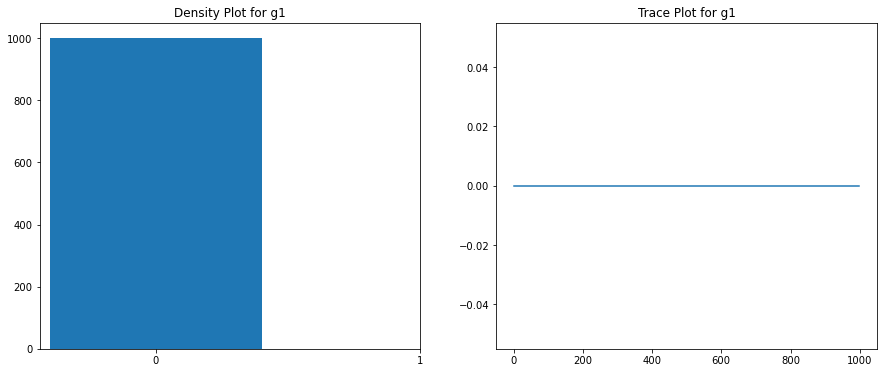

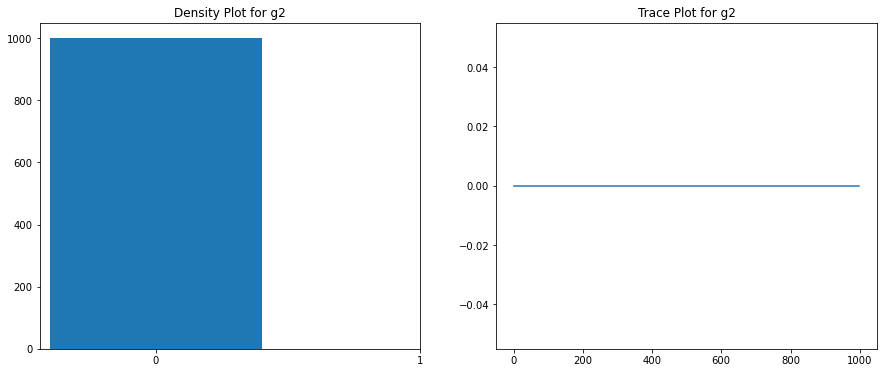

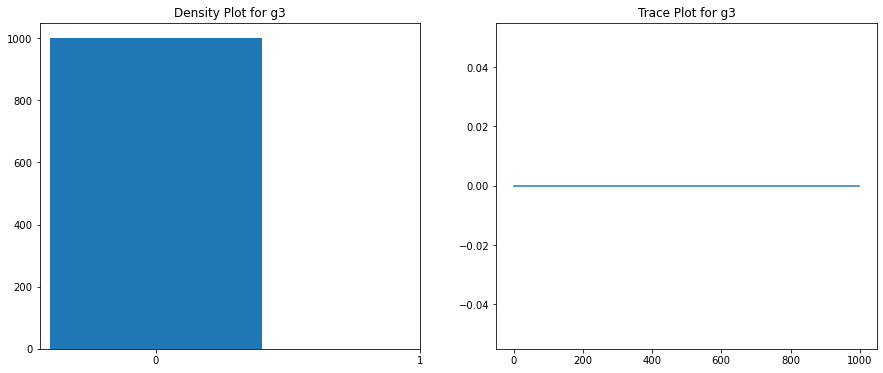

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


for i in range(g_samples1.shape[1]):
    chain = g_samples1[:, i]
    num, count = np.unique(chain, return_counts = True)
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.bar(num, count)
    plt.title('Density Plot for g' + str(i + 1))
    plt.xticks([0, 1])
    #plt.hist(chain, density = True, nbins = 100)
    plt.subplot(122)
    plt.plot(np.arange(chain.shape[0]),chain)
    plt.title('Trace Plot for g' + str(i + 1))
    plt.show()
    

##### $\beta$

KeyboardInterrupt: 

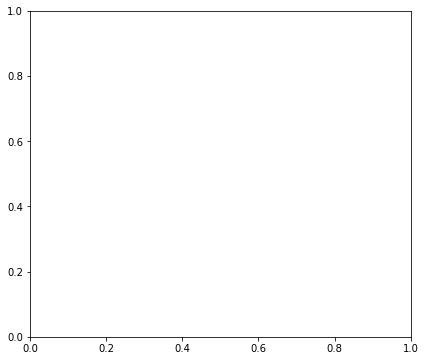

In [15]:
for i in range(beta_samples1.shape[1]):
    chain = beta_samples1[:, i]
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    sns.histplot(chain,  kde=True, stat = "density", binwidth= 0.1)
    plt.title('Density Plot for $\\beta$' + str(i + 1))
    plt.xlim(-5, 5)
    
    plt.subplot(122)
    plt.plot(np.arange(chain.shape[0]),chain)
    plt.title('Trace Plot for $\\beta$' + str(i + 1))
    plt.ylim(-10, 10)
    plt.show()
    

##### $\alpha$

In [ ]:
chain = alpha_samples1.reshape(-1)
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.histplot(chain,  kde=True, stat = "density", binwidth= 0.001)
plt.title('Density Plot for $\\alpha$')
#plt.xlim(-5, 5)

plt.subplot(122)
plt.plot(np.arange(chain.shape[0]),chain)
plt.title('Trace Plot for $\\alpha$')
#plt.ylim(-10, 10)
plt.show()

##### Posterior estimate of  g

We expect them to be (0, 0.5, 0.5)

In [ ]:
np.stack(g_samples1).mean(axis = 0)

##### Posterior estimate of $\alpha$
We expect it be 0.

In [ ]:
alpha_samples1.mean()

## Conclusion

From what has been showed above, the result of hand-writing version is consistent with the result from PyMC3. The posterior expectation of $\tilde{g_1}$, $\tilde{g_2}$, $\tilde{g_3}$ are approximately 0, 0.5, 0.5. Also, for $\tilde{\alpha}$, the posterior estimator is very close to 0. These results are what we expected before simulation.